In [1]:
using Statistics
using DataFrames
using Queryverse
using VegaLite
using MLJ
using MLJBase
using ShapML

## Objective

The objective is to fit a regression model that predicts concrete strength from a number of factors.

## Data Description 

The data consist of the target variable concrete_strength along with the predictor variables: cement, blast_furnace, fly_ash, water, superplasticizer, coarse_aggregate, fine_aggregate and age.  All variables are continous.

## Data Load

The concrete data was imported from a physical computer hard drive.

In [2]:
# Upload Data
concrete = Queryverse.load("/home/chigball/Data/concrete.csv") |>
@mutate(age = float(_.age)) |>DataFrame
preview = first(concrete, 4);
show(preview, allcols = true)


4×9 DataFrame
│ Row │ cement  │ blast_furnace │ fly_ash │ water   │ superplasticizer │
│     │ Float64 │ Float64       │ Float64 │ Float64 │ Float64          │
├─────┼─────────┼───────────────┼─────────┼─────────┼──────────────────┤
│ 1   │ 540.0   │ 0.0           │ 0.0     │ 162.0   │ 2.5              │
│ 2   │ 540.0   │ 0.0           │ 0.0     │ 162.0   │ 2.5              │
│ 3   │ 332.5   │ 142.5         │ 0.0     │ 228.0   │ 0.0              │
│ 4   │ 332.5   │ 142.5         │ 0.0     │ 228.0   │ 0.0              │

│ Row │ coarse_aggregate │ fine_aggregate │ age     │ concrete_strength │
│     │ Float64          │ Float64        │ Float64 │ Float64           │
├─────┼──────────────────┼────────────────┼─────────┼───────────────────┤
│ 1   │ 1040.0           │ 676.0          │ 28.0    │ 79.99             │
│ 2   │ 1055.0           │ 676.0          │ 28.0    │ 61.89             │
│ 3   │ 932.0            │ 594.0          │ 270.0   │ 40.27             │
│ 4   │ 932.0            │ 594

## Data Summary

There are no missing of duplicate values in the data. 

In [3]:
describe(concrete)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Nothing,DataType
1,cement,281.168,102.0,272.9,540.0,,,Float64
2,blast_furnace,73.8958,0.0,22.0,359.4,,,Float64
3,fly_ash,54.1883,0.0,0.0,200.1,,,Float64
4,water,181.567,121.8,185.0,247.0,,,Float64
5,superplasticizer,6.20466,0.0,6.4,32.2,,,Float64
6,coarse_aggregate,972.919,801.0,968.0,1145.0,,,Float64
7,fine_aggregate,773.58,594.0,779.5,992.6,,,Float64
8,age,45.6621,1.0,28.0,365.0,,,Float64
9,concrete_strength,35.818,2.33,34.445,82.6,,,Float64


## Correlation to Concrete Strength
Important variables are cement, superplasticizer and age


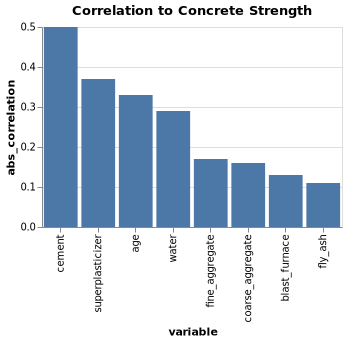

In [4]:
# Create empty cortable dataframe (var1, var2, correlation)
cortable = DataFrame(var1 = Symbol[], var2 = Symbol[], correlation = Float64[]);

# Populate the columns
for i in names(concrete), j in names(concrete)
  push!(cortable, (i, j, cor(concrete[!, i], concrete[!, j])))
end

# Manipulate table for ploting 
cordata = cortable |>
@filter(_.var1 != :concrete_strength) |>
@filter(_.var2 == :concrete_strength) |>
@mutate(abs_correlation = abs(_.correlation)) |>
@mutate(abs_correlation = round(_.abs_correlation, digits = 2)) |>
@rename(:var1 => :variable) |>
@select(:variable, :abs_correlation) |>
DataFrame


# Create Vegalite plot
@vlplot(
  data = cordata,
  mark = :bar,
  x = {"variable:n", sort = "-y"},
  y = "abs_correlation:q",
  title = "Correlation to Concrete Strength",
  height = 200,
  width = 300
  
)



In [5]:
X = concrete |> @select(-:concrete_strength) |> DataFrame;
y = concrete.concrete_strength;

In [6]:
mymodels = models() |> 
@filter(_.package_name in ["NearestNeighbors"]) |>
@select(:name, :package_name, :prediction_type, :docstring) |>
@orderby(_.package_name) |>
DataFrame




,name,package_name,prediction_type,docstring
,String,String,Symbol,String
1,KNNClassifier,NearestNeighbors,probabilistic,"K-Nearest Neighbors classifier: predicts the class associated with a new point\nby taking a vote over the classes of the K-nearest points.\n\n→ based on [NearestNeighbors](https://github.com/KristofferC/NearestNeighbors.jl).\n→ do `@load KNNClassifier pkg=""NearestNeighbors""` to use the model.\n→ do `?KNNClassifier` for documentation."
2,KNNRegressor,NearestNeighbors,deterministic,"K-Nearest Neighbors regressor: predicts the response associated with a new point\nby taking an average of the response of the K-nearest points.\n\n→ based on [NearestNeighbors](https://github.com/KristofferC/NearestNeighbors.jl).\n→ do `@load KNNRegressor pkg=""NearestNeighbors""` to use the model.\n→ do `?KNNRegressor` for documentation."


In [7]:
# Select X and y
X = concrete |> @select(-:concrete_strength) |> DataFrame;
y = concrete.concrete_strength;


# Create pipeline
@load KNNRegressor 
pipe = @pipeline MyPipe2(
  std = Standardizer(),
  target = x -> x ./ 100, 
  knnr = KNNRegressor(),
  inverse = x -> x .* 100
)

MyPipe2(
    std = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    target = StaticTransformer(
            f = var"#49#50"()),
    knnr = KNNRegressor(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    inverse = StaticTransformer(
            f = var"#51#52"())) @ 4…36

In [8]:
mach = machine(pipe, X, y)
fit!(mach)

┌ Info: Training Machine{MyPipe2} @ 7…13.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{Standardizer} @ 1…32.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{StaticTransformer} @ 3…25.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{KNNRegressor} @ 1…32.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Training NodalMachine{StaticTransformer} @ 1…44.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187


Machine{MyPipe2} @ 7…13



## Model Evaluation
The model was evaluated under 8-fold cross validation for mae and rms.  


In [9]:
evaluate!(mach, 
  resampling=CV(nfolds=8, rng=1234),
  measures=[mae, rms],  
  check_measure=false
)

Evaluating over 8 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬──────────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                       │
├───────────┼───────────────┼──────────────────────────────────────────────────┤
│ mae       │ 6.57          │ [6.36, 7.15, 6.49, 6.45, 6.2, 6.75, 6.72, 6.45]  │
│ rms       │ 8.5           │ [7.96, 9.26, 8.44, 8.23, 8.19, 8.59, 8.73, 8.56] │
└───────────┴───────────────┴──────────────────────────────────────────────────┘
_.per_observation = [missing, missing]


In [10]:
# Function to plot learning curves

function plot_lc(curve::NamedTuple, measure::String)
  
  # Create a dataframe from data
  df = DataFrame(parameter_values = curve.parameter_values, measurements = curve.measurements)
  
  # Use vlplot to plot data  
  @vlplot(
    data = df,
    mark = {:line, tooltip = true, point = true},
    x = {"parameter_values:q", title = curve.parameter_name},
    y = {"measurements:q", title = measure},
    title = "Learning Curve",
    height = 250,
    width = 260
  )  

end

# Define ranges for tuning

r1 = range(pipe, :(knnr.K), lower=1, upper = 10) 
r2 = range(pipe, :(knnr.leafsize), lower=1, upper = 20) 

# Create 2 learning curves

curve1 = learning_curve(mach; range=r1, resampling=CV(), measure=rms);
curve2 = learning_curve(mach; range=r2, resampling=CV(), measure=rms);

# First learning curve
p1 = plot_lc(curve1, "rms");

# Second learning curve
p2 = plot_lc(curve2, "rms");



┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @ 1…81.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Attempting to evaluate 10 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 10 metamodels: 100%[=========================] Time: 0:00:00
┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @ 7…62.
└ @ MLJBase /home/chigball/.julia/packages/MLJBase/O5b6j/src/machines.jl:187
┌ Info: Attempting to evaluate 20 models.
└ @ MLJTuning /home/chigball/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 20 metamodels: 100%[=========================] Time: 0:00:00


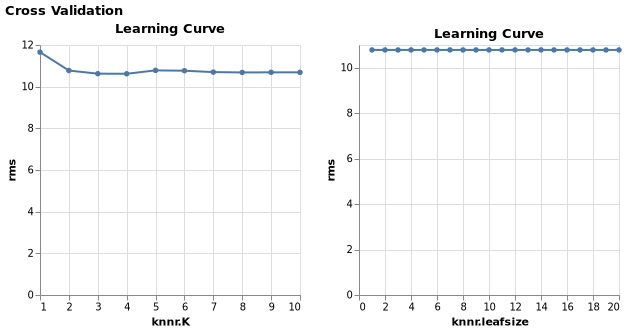

In [11]:
@vlplot(title = "Cross Validation") + [p1 p2]

## Variable Importance

The chart below ranks variables in types of contribuion to the model.  This was done under the Shapley framework.  

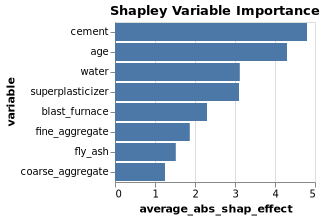

In [12]:
# Get a sample of values
explain  = X |> @take(1000) |> DataFrame;

# Prediction function to dataframe
function predict_function(model, data)
  data_pred = DataFrame(y_pred = predict(model, data))
  return data_pred
end


# Compute stochastic Shapley values.
data_shap = ShapML.shap(explain = explain,
                        model = mach,
                        predict_function = predict_function,
                        sample_size = 60,
                        seed = 1
                        );

# Calculate Average Absolute Shapley Effect
shap_df = data_shap |> 
@select(:index, :feature_name, :shap_effect) |>
@mutate(abs_shap_effect = abs(_.shap_effect)) |>
@groupby(_.feature_name) |>
@map({variable = key(_), average_abs_shap_effect = mean(_.abs_shap_effect)}) |>
@mutate(average_abs_shap_effect = round(_.average_abs_shap_effect, digits = 2)) |>
@orderby_descending(_.average_abs_shap_effect) |> DataFrame;

# Plot the results
@vlplot(
  data = shap_df,
  mark = :bar,
  y = {"variable:n", sort = "-x"},
  x = "average_abs_shap_effect:q",
  title = "Shapley Variable Importance"
)